# Генеративно-состязательные сети (Generative Adversarial Networks)

В задании предлагается реализовать GAN, обучить её на MNIST, оценить правдоподобие и сделать выводы.

Необходимая теория приведена ниже.

Актуальная версия доступна по адресу https://github.com/nadiinchi/dl_labs/blob/master/lab_gan.ipynb

## Постановка задачи
Дана выборка независимых одинаково распределенных величин из истинного распределения $x_i \sim p_d(x)$, $i = 1, \dots, N$.

Задача - построить вероятностную модель $p_\theta(x)$ истинного распределения $p_d(x)$.

Распределение $p_\theta(x)$ должно позволять как оценить плотность вероятности для данного объекта $x$, так и сэмплировать $x \sim p_\theta(x)$.

## Вероятностная модель
$z \in \mathbb{R}^d$ - локальная латентная переменная, т. е. своя для каждого объекта $x \in \mathbb{R}^D$.

Генеративный процесс вариационного автокодировщика:
1. Сэмплируем $z \sim p(z)$.
2. $x = G_\theta(z)$.

Параметры преобразования $G_\theta(z)$ задаются нейросетью с весами $\theta$, получающей на вход вектор $z$.

Индуцированная генеративным процессом плотность вероятности объекта $x$:

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z))$$

## Оценка логарифма правдоподобия
Для оценки логарифма правдоподобия используется метод Парзеновского окна/ядерного сглаживания (англ. Kernel Density Estimation/Parzen–Rosenblatt window method). Концептуально он заключается в том, что мы сглаживаем модельное распределение, и по этому сглаженному распределению вычисляем правдоподобие модели.

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z)) \approx \frac{1}{Mh^D}\sum_{i=1}^M K\left(\frac{x - G_\theta(z_i)}{h}\right)$$

Здесь $K(x)$ - любое распределение, а $h$ - ширина окна. Тогда выполняется

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{Mh^D}\sum_{j=1}^M K\left(\frac{x_i - G_\theta(z_j)}{h}\right)$$

В генеративно-состязательных сетях для оценки правдоподобия используется стандартное нормальное распределение $K(x) = N(x | 0, I)$. Тогда получаем

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{M}\sum_{j=1}^M \prod_{k=1}^D\frac{1}{\sqrt{2 \pi} \sigma}\exp\left(-\frac{(x_{i,k} - G(z_j)_k)^2}{2\sigma^2}\right)$$

Коэффициент $\sigma$ настраивается на валидационной выборке и с его помощью считается правдоподобие тестовой выборки.

### Загрузка, нормировка и визуалиация данных

In [1]:
import math
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
torch.random.manual_seed(42)
np.random.seed(42)

In [2]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255)
data = MNIST('mnist', download=True, train=False)
test_data_raw = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255)

C:\Users\Evgeniya\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Evgeniya\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [3]:
digit_size = 14

In [4]:
train_data.tensors = (nn.AvgPool2d(2, 2)(train_data.tensors[0].view(-1, 28, 28)).data.view(-1, 196), )
test_data_raw.tensors = (nn.AvgPool2d(2, 2)(test_data_raw.tensors[0].view(-1, 28, 28)).data.view(-1, 196), )

In [5]:
valid_data = TensorDataset(test_data_raw.tensors[0][:5000])
test_data = TensorDataset(test_data_raw.tensors[0][5000:])

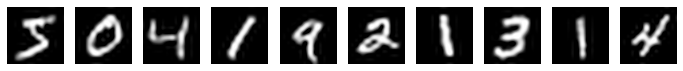

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, digit_size, digit_size)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(train_data[:10][0])

In [7]:
n = 15

from scipy.stats import norm
import numpy as np

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(generator):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])

            x_decoded = generator(z_sample)
            digit = x_decoded
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')
    plt.show()

### Функции и классы, описывающие модель и процесс её обучения

In [8]:
class Reshape(nn.Module):
    def __init__(self, *args):
        """
        Запоминает размерности, в которые при проходе
        вперед будут переводиться все объекты.
        Например,
            input = torch.zeros(100, 196)
            reshape_layer = Reshape(1, 14, 14)
            reshape_layer(input)
        возвращает тензор размерности (100, 1, 14, 14).
            input = torch.zeros(100, 1, 14, 14)
            reshape_layer = Reshape(-1)
            reshape_layer(input)
        наоборот вернет тензор размерности (100, 196).
        """
        super(type(self), self).__init__()
        self.dims = args

    def forward(self, input):
        """
        Возвращает тензор с измененными размерностями объектов.
        Вход: input, FloatTensor.
        Возвращаемое значение: FloatTensor.
        """
        return input.view(input.size(0), *self.dims)

In [9]:
class GAN(nn.Module):
    def __init__(self, d):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        # Можно пробовать другие архитектуры: как более сложные
        # сверточные, так и более простые, например, полносвязные.
        # Однако желательно обучить хотя бы одну сверточную модель.
        self.discriminator = nn.Sequential(
            Reshape(1, 14, 14),
            nn.Conv2d(1, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, 3, 2, 0, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, 3, 1, 0, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            Reshape(-1),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        self.generator = nn.Sequential(
            Reshape(self.d, 1, 1),
            nn.ConvTranspose2d(self.d, 128, 4, 1, 0, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, 2, 1, 1, bias=False),
            Reshape(-1),
            nn.Sigmoid()
        )

    def generate_noise(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x d.
        """
        z = torch.from_numpy(np.random.randn(num_samples, self.d)).float()
        if next(self.parameters()).is_cuda:
            z = z.cuda()
        return z

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x D.
        """
        return self.generator(self.generate_noise(num_samples))

    def discriminator_loss(self, batch):
        """
        Вычисляет значение функции потерь дискриминатора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Tensor, скаляр - значение функции потерь
        дискриминатора на данном батче.
        """
        return - torch.mean(torch.log(self.discriminator(batch)) + torch.log(1 - self.discriminator(self.generate_samples(batch.shape[0])))) #1 - в тензор

    def generator_loss(self, batch_size):
        """
        Вычисляет значение функции потерь генератора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Tensor, скаляр - значение функции потерь
        генератора на данном батче.
        """
        return -torch.mean(torch.log(self.discriminator(self.generate_samples(batch_size))))

In [10]:
def log_mean_exp(mtx):
    """
    Возвращает логарифм среднего по каждому столбцу от экспоненты данной матрицы.
    Подсказка: не забывайте про вычислительную стабильность!
    Вход: mtx, Tensor - матрица размера n x k.
    Возвращаемое значение: Tensor, вектор длины n.
    """
    max_a = torch.max(mtx, dim=0)[0]
    log_mean_e_mtx = max_a + torch.log(torch.mean(torch.exp(mtx - max_a), dim=0))
    return log_mean_e_mtx

In [11]:
def log_likelihood(generated_set, validation_set, test_set):
    """
    Возвращает оценку логарифма правдоподобия модели GAN методом
    Парзеновского окна со стандартным нормальным ядром.
    Подсказка: sigma должна настраиваться по валидационной выборке, а
    правдоподобие считаться по тестовой.
    Подсказка: вместо sigma можно настраивать log_sigma.
    Подсказка: для настойки sigma допустимо использовать как перебор по сетке,
    так и другие методы опимизации.
    Вход: generated_set - сэмплы из генеративной модели.
    Вход: validation_set - валидационная выборка.
    Вход: test_set - тестовая выборка.
    Возвращаемое значение: float (не Tensor!) - оценка логарифма правдоподобия.
    """
    b_s = 512
    
    def ll(x, g, sigm):
        return - x.shape[-1] * torch.log(2 * np.pi * sigm**2) / 2 + log_mean_exp(-((x.unsqueeze(0) - g.unsqueeze(1))**2).sum(dim = -1) / (2 * sigm**2)).mean()
        
    sigma = torch.randn(10)
    losses = []
    opt = 0
    l_max = -99999
    for i, s in enumerate(sigma):
        l_0 = 0
        for j in validation_set:
            l_0 += ll(j, generated_set, s)
        l_0 = l_0/validation_set.shape[0]
        if len(losses) != 0 and l_0 >= l_max:
            opt = i
            l_max = l_0
        losses.append(l_0) 
        
    loss = 0
    for k in test_set:
        loss += ll(k, generated_set, sigma[opt])
    return loss / test_set.shape[0]

In [12]:
def generate_many_samples(model, num_samples, batch_size):
    size = 0
    res = []
    while size < num_samples:
        res.append(model.generate_samples(min(batch_size, num_samples - size)))
        size += batch_size
    return torch.cat(res, 0)

In [13]:
def train_model(model, num_epochs=100, b_s=128):
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: k, int - число итераций оптимизации дискриминатора на итерацию оптимизации
    генератора.
    Вход: batch_size, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'generator_losses' - список значений функции потерь генератора,
    'discriminator_losses' - список значений функции потерь дискриминатора.
    """
    if torch.cuda.is_available():
        model = model.cuda()
    model.train()

    # возможно, нужно подобрать другие параметры, чтобы модель обучилась
    batch_size = b_s
    learning_rate = 2e-4

    # возможно, нужно использовать другие методы оптимизации или параметры методов оптимизации,
    # чтобы модель обучилась
    gd_generator = optim.Adam(model.generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    gd_discriminator = optim.RMSprop(model.discriminator.parameters(), lr=learning_rate)

    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    total_batches = len(dataloader)

    generator_losses = [0]
    discriminator_losses = [0]
    log_likelihoods = []

    generated_samples = generate_many_samples(model, 512, batch_size).detach()
    valid_samples = valid_data[np.random.choice(len(valid_data), 512, False)][0]
    valid_samples = valid_samples.to(next(model.parameters()).device)
    test_samples = test_data[np.random.choice(len(test_data), 512, False)][0]
    test_samples = test_samples.to(next(model.parameters()).device)
    ll = log_likelihood(generated_samples, valid_samples, test_samples)
    log_likelihoods.append(ll)
    print('Log-likelihood', ll, flush=True)

    for epoch in range(num_epochs):
        for i, (batch, ) in enumerate(dataloader):
            if torch.cuda.is_available():
                batch = batch.cuda()

            gd_generator.zero_grad()
            g_loss = model.generator_loss(batch_size) 
            g_loss.backward()
            gd_generator.step()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            
            gd_discriminator.zero_grad()
            d_loss = model.discriminator_loss(batch)
            d_loss.backward()
            gd_discriminator.step()

            # разрешается менять код этой функции для реализации
            # более сложных процедур обучения или ускорения обучения

            # не забудьте корректно сохранить статистику
            discriminator_losses.append(float(d_loss))
            generator_losses.append(float(g_loss))

            if (i + 1) % 100 == 0:
                print('\rEpoch:', epoch, 'G_loss:', generator_losses[-1],
                      'D_loss:', discriminator_losses[-1],
                      'Batch', i + 1, 'of', total_batches,
                      ' ' * 10, end='', flush=True)

        print(flush=True)
        generated_samples = generate_many_samples(model, 512, batch_size).detach()
        valid_samples = valid_data[np.random.choice(len(valid_data), 512, False)][0]
        valid_samples = valid_samples.to(next(model.parameters()).device)
        test_samples = test_data[np.random.choice(len(test_data), 512, False)][0]
        test_samples = test_samples.to(next(model.parameters()).device)
        ll = log_likelihood(generated_samples, valid_samples, test_samples)
        log_likelihoods.append(ll)
        print('Log-likelihood', ll, flush=True)

    return {
        'model': model.cpu(),
        'generator_losses': generator_losses,
        'discriminator_losses': discriminator_losses,
        'log_likelihoods': log_likelihoods
    }

### Обучение модели

In [36]:
g2 = GAN(2)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d2 = train_model(g2, num_epochs=30, b_s=128)

g2 = GAN(2)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d2 = train_model(g2, num_epochs=15, b_s=128)

Log-likelihood tensor(-156.8005, device='cuda:0')
Epoch: 0 G_loss: 0.7657780647277832 D_loss: 1.3046693801879883 Batch 400 of 469           
Log-likelihood tensor(-161.3861, device='cuda:0')
Epoch: 1 G_loss: 0.8501360416412354 D_loss: 1.133455753326416 Batch 400 of 469            
Log-likelihood tensor(-138.0117, device='cuda:0')
Epoch: 2 G_loss: 0.796656608581543 D_loss: 1.2498513460159302 Batch 400 of 469            
Log-likelihood tensor(-26.6482, device='cuda:0')
Epoch: 3 G_loss: 0.8401257395744324 D_loss: 1.2116148471832275 Batch 400 of 469           
Log-likelihood tensor(-135.6672, device='cuda:0')
Epoch: 4 G_loss: 0.96158367395401 D_loss: 1.0402178764343262 Batch 400 of 469             
Log-likelihood tensor(-34.1719, device='cuda:0')
Epoch: 5 G_loss: 0.8825173377990723 D_loss: 1.1866248846054077 Batch 400 of 469           
Log-likelihood tensor(4.8306, device='cuda:0')
Epoch: 6 G_loss: 1.1079537868499756 D_loss: 1.0997480154037476 Batch 400 of 469           
Log-likelihood ten

In [23]:
g5 = GAN(5)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d5 = train_model(g5, num_epochs=45)

Log-likelihood tensor(-136.4235, device='cuda:0')
Epoch: 0 G_loss: 0.7289180755615234 D_loss: 1.334423542022705 Batch 400 of 469            
Log-likelihood tensor(-55.0297, device='cuda:0')
Epoch: 1 G_loss: 0.7305214405059814 D_loss: 1.344085931777954 Batch 400 of 469            
Log-likelihood tensor(-1.3726, device='cuda:0')
Epoch: 2 G_loss: 0.7362165451049805 D_loss: 1.346455454826355 Batch 400 of 469            
Log-likelihood tensor(25.7695, device='cuda:0')
Epoch: 3 G_loss: 0.7295933365821838 D_loss: 1.3386318683624268 Batch 400 of 469           
Log-likelihood tensor(32.9058, device='cuda:0')
Epoch: 4 G_loss: 0.761110782623291 D_loss: 1.3385393619537354 Batch 400 of 469            
Log-likelihood tensor(34.7909, device='cuda:0')
Epoch: 5 G_loss: 0.7459728717803955 D_loss: 1.2901291847229004 Batch 400 of 469           
Log-likelihood tensor(30.6994, device='cuda:0')
Epoch: 6 G_loss: 0.8019444346427917 D_loss: 1.3236130475997925 Batch 400 of 469           
Log-likelihood tensor(39

In [24]:
g10 = GAN(10)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d10 = train_model(g10, num_epochs=60)

Log-likelihood tensor(-159.8289, device='cuda:0')
Epoch: 0 G_loss: 0.7667648196220398 D_loss: 1.2548736333847046 Batch 400 of 469           
Log-likelihood tensor(-92.6982, device='cuda:0')
Epoch: 1 G_loss: 0.7365782856941223 D_loss: 1.3236182928085327 Batch 400 of 469           
Log-likelihood tensor(27.1438, device='cuda:0')
Epoch: 2 G_loss: 0.7143798470497131 D_loss: 1.348935604095459 Batch 400 of 469            
Log-likelihood tensor(26.2847, device='cuda:0')
Epoch: 3 G_loss: 0.7456724643707275 D_loss: 1.3193551301956177 Batch 400 of 469           
Log-likelihood tensor(15.7699, device='cuda:0')
Epoch: 4 G_loss: 0.7913205027580261 D_loss: 1.3323192596435547 Batch 400 of 469           
Log-likelihood tensor(22.7438, device='cuda:0')
Epoch: 5 G_loss: 0.7653380036354065 D_loss: 1.3091273307800293 Batch 400 of 469           
Log-likelihood tensor(-150.1357, device='cuda:0')
Epoch: 6 G_loss: 0.7586436867713928 D_loss: 1.2793797254562378 Batch 400 of 469           
Log-likelihood tensor(

Epoch: 58 G_loss: 0.7357418537139893 D_loss: 1.2755286693572998 Batch 400 of 469           
Log-likelihood tensor(58.5047, device='cuda:0')
Epoch: 59 G_loss: 0.8700072169303894 D_loss: 1.2873166799545288 Batch 400 of 469           
Log-likelihood tensor(48.3188, device='cuda:0')
Wall time: 11min 38s


In [25]:
g100 = GAN(100)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d100 = train_model(g100, num_epochs=30)

Log-likelihood tensor(-166.5976, device='cuda:0')
Epoch: 0 G_loss: 0.7592154741287231 D_loss: 1.2657105922698975 Batch 400 of 469           
Log-likelihood tensor(-136.4122, device='cuda:0')
Epoch: 1 G_loss: 0.8107948303222656 D_loss: 1.1693172454833984 Batch 400 of 469           
Log-likelihood tensor(-30.7405, device='cuda:0')
Epoch: 2 G_loss: 0.846488356590271 D_loss: 1.2560003995895386 Batch 400 of 469            
Log-likelihood tensor(22.5693, device='cuda:0')
Epoch: 3 G_loss: 0.8517468571662903 D_loss: 1.2060214281082153 Batch 400 of 469           
Log-likelihood tensor(26.3212, device='cuda:0')
Epoch: 4 G_loss: 0.8899790048599243 D_loss: 1.2205023765563965 Batch 400 of 469           
Log-likelihood tensor(28.1070, device='cuda:0')
Epoch: 5 G_loss: 0.8157227039337158 D_loss: 1.1512668132781982 Batch 400 of 469           
Log-likelihood tensor(4.9181, device='cuda:0')
Epoch: 6 G_loss: 0.890245795249939 D_loss: 1.1596717834472656 Batch 400 of 469            
Log-likelihood tensor(2

### Анализ результатов

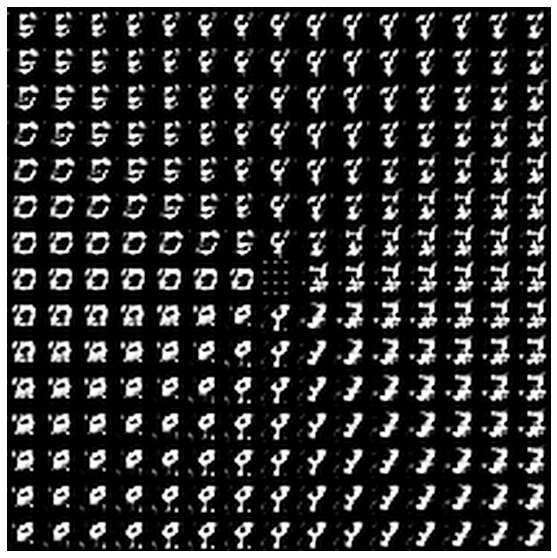

In [37]:
def draw_manifold_gan(model):
    generator = lambda z: model.generator(torch.from_numpy(z).float()).view(digit_size, digit_size).data.numpy()
    return draw_manifold(generator)

draw_manifold_gan(gan_model_d2['model'])

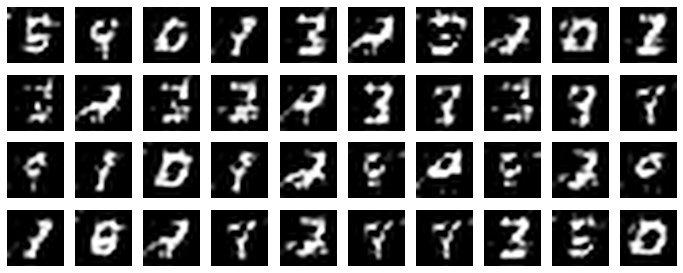

In [38]:
show_images(gan_model_d2['model'].generate_samples(40))

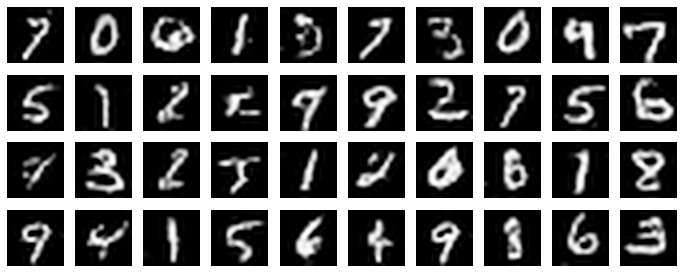

In [39]:
show_images(gan_model_d5['model'].generate_samples(40))

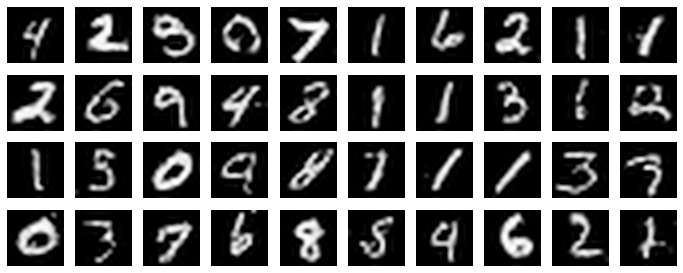

In [29]:
show_images(gan_model_d10['model'].generate_samples(40))

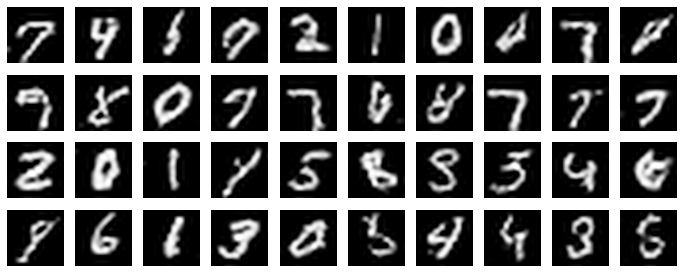

In [30]:
show_images(gan_model_d100['model'].generate_samples(40))

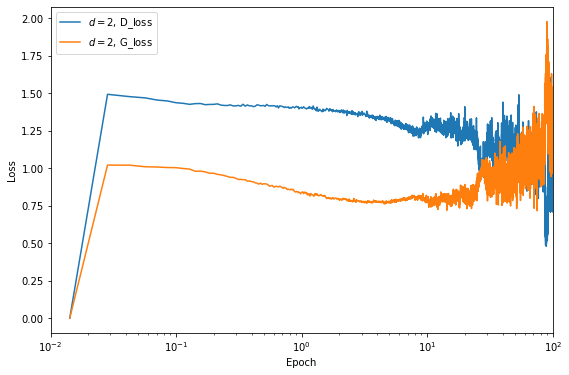

In [40]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, D_loss', 'discriminator_losses', gan_model_d2),
    ('$d = 2$, G_loss', 'generator_losses', gan_model_d2),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

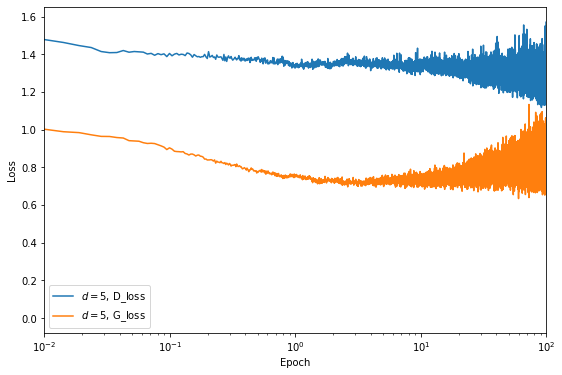

In [32]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 5$, D_loss', 'discriminator_losses', gan_model_d5),
    ('$d = 5$, G_loss', 'generator_losses', gan_model_d5),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

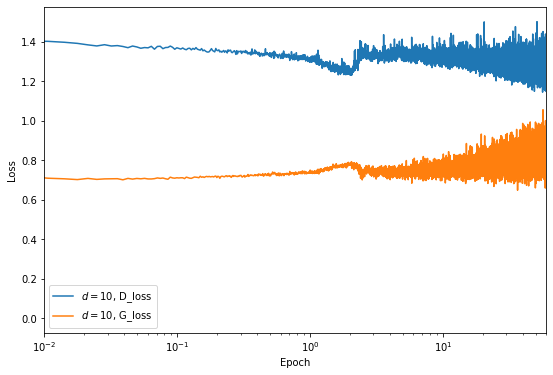

In [33]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 10$, D_loss', 'discriminator_losses', gan_model_d10),
    ('$d = 10$, G_loss', 'generator_losses', gan_model_d10),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=60)
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

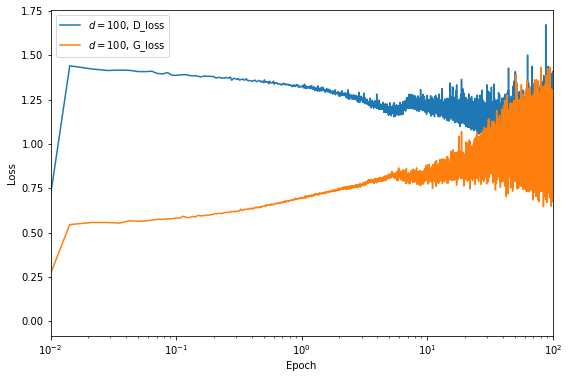

In [34]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 100$, D_loss', 'discriminator_losses', gan_model_d100),
    ('$d = 100$, G_loss', 'generator_losses', gan_model_d100),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

In [28]:
generated_samples = generate_many_samples(gan_model_d2['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

Wall time: 2min 29s


tensor(nan)

In [29]:
generated_samples = generate_many_samples(gan_model_d10['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

Wall time: 2min 34s


tensor(85.7550)

In [30]:
generated_samples = generate_many_samples(gan_model_d100['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

Wall time: 2min 29s


tensor(10.0106)

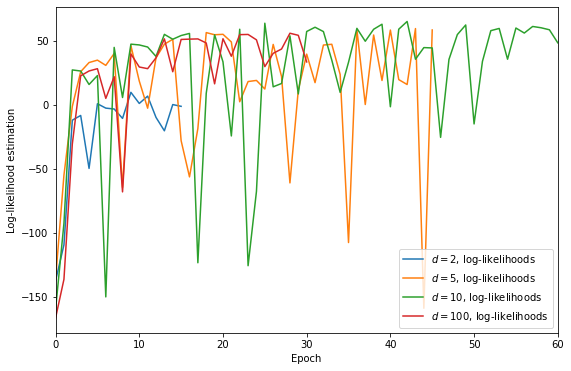

In [41]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, log-likelihoods', 'log_likelihoods', gan_model_d2),
    ('$d = 5$, log-likelihoods', 'log_likelihoods', gan_model_d5),
    ('$d = 10$, log-likelihoods', 'log_likelihoods', gan_model_d10),
    ('$d = 100$, log-likelihoods', 'log_likelihoods', gan_model_d100),
]:
    data = model[name]
    x_labels = np.arange(len(data))
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.0, xmax=60)
plt.ylabel('Log-likelihood estimation')
plt.legend()
pass

## Выводы
По результатам проведенных экспериментов решено было остановиться на размере батча 128 (кроме d2, где было решено оставить 64), он оптимелен по скорости обучения моделей и качеству. 

Кроме того для $d = 10$ понадобилось больше всего итераций для обучения (60), чтобы достичь стабильных значений в функциях ошибки.

Модель принимающая на вход двумерный вектор работает хуже, чем модели с большей размерностью векторов. Можно связать это с меньшей вариативностью входных чисел в векторах, которые соответственно несут меньше информации для модели. 

Целью при обучении были более стабильные оценки лосса, имеющие одинаковую тенденцию для генератора и дискриминатора. 

При проектировании обучения модели, генератор выносился за цикл обучения дискриминатора, что приводило к недообучению генератора, плохим картинкам и резкому росту лосса генератора / паделию лосса дискриминатора. То есть дискриминатор обучался отличать картинки слишком быстро, и уже не нес должной информации для генератора. В связи с этим его обучение в итоге проводится параллельно: в каждом батче каждой эпохи первым шагом учится генератор, вторым дискриминатор. 

График правдоподобия имеет медленную но тенденцию к росту для всех моделей. Хотя видно нестабильность значений, они не падают ниже стартовой точки. Несмотря на не столь хорошее качество генератора в случае двумерных векторов, правдободобие тем не менее имеет меньший разброс значений, хоть и в среднем ниже конкурирующих моделей.

Была добавлена модель с векторами $\in \mathcal{R}^{5}$. При обучении на 45 эпохах она дает результаты сравнимые с $\in \mathcal{R}^{100}$. Слабая разница в визуальном результате может быть связана с тем, что исходные картинки не столь разнообразны и чтобы закодировать информацию о них нужно не так много данных. При высоком разрешении и добавлении цвета результат скорее всего будет очевиднее. При этом по правдоподобию такая модель стабильнее до 30ти эпох обучения, и в среднем выше предшественника с $d = 2$. 

Интересное замечание, модель с $d = 2$ обучается не с первого раза. Если её обучить, а потом заново инициализировать и снова обучить, то качество картинок выше. Так что можно предположить, случайность присутствующая в процессе обучения, оказывает большое влияние в случае столь малых размерностей.